### Basic data analysis or exploratory data analysis (EDA)

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read Training dataset as well as drop the index column
training_data = pd.read_csv('./cs-training.csv').drop('Unnamed: 0', axis = 1)


# For each column heading we replace "-" and convert the heading in lowercase 
cleancolumn = []
for i in range(len(training_data.columns)):
    cleancolumn.append(training_data.columns[i].replace('-', '').lower())
training_data.columns = cleancolumn

In [4]:
# print the 5 records of the traiing dataset
training_data.head()

,seriousdlqin2yrs,revolvingutilizationofunsecuredlines,age,numberoftime3059dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,numberrealestateloansorlines,numberoftime6089dayspastduenotworse,numberofdependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### Handle the outliers

In [5]:
training_data = training_data.fillna(training_data.median())

In [6]:
training_data.isna().sum()

seriousdlqin2yrs                        0
revolvingutilizationofunsecuredlines    0
age                                     0
numberoftime3059dayspastduenotworse     0
debtratio                               0
monthlyincome                           0
numberofopencreditlinesandloans         0
numberoftimes90dayslate                 0
numberrealestateloansorlines            0
numberoftime6089dayspastduenotworse     0
numberofdependents                      0
dtype: int64

In [8]:
import pandas as pd
import numpy as np

# Example DataFrame

df = training_data

# Function to adjust values to fit within the IQR
def adjust_to_iqr(df):
    for column in df.columns:
        if column == 'seriousdlqin2yrs':
            continue  # Skip the excluded column
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

    return df

# Adjust DataFrame
training_data = adjust_to_iqr(df)

# Show the adjusted DataFrame
print(training_data.head())

   seriousdlqin2yrs  revolvingutilizationofunsecuredlines   age  \
0                 1                              0.766127  45.0   
1                 0                              0.957151  40.0   
2                 0                              0.658180  38.0   
3                 0                              0.233810  30.0   
4                 0                              0.907239  49.0   

   numberoftime3059dayspastduenotworse  debtratio  monthlyincome  \
0                                  0.0   0.802982         9120.0   
1                                  0.0   0.121876         2600.0   
2                                  0.0   0.085113         3042.0   
3                                  0.0   0.036050         3300.0   
4                                  0.0   0.024926        12645.5   

   numberofopencreditlinesandloans  numberoftimes90dayslate  \
0                             13.0                      0.0   
1                              4.0                      0.0   

## Train and build baseline model

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, roc_curve
import lightgbm as lgb

In [10]:
X = training_data.drop('seriousdlqin2yrs', axis=1)
y = training_data.seriousdlqin2yrs

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#### Gradientboosting Classifier

In [12]:
gbMod = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                   max_depth=3,
                                   init=None, random_state=None, max_features=None, verbose=0)

In [13]:
gbMod.fit(X_train, y_train)

GradientBoostingClassifier(loss='exponential', n_estimators=200)

In [14]:
gbMod.score(X_test, y_test)

0.9337333333333333

In [15]:
test_labels=gbMod.predict_proba(np.array(X_test.values))[:,1]

In [16]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8080912179557171

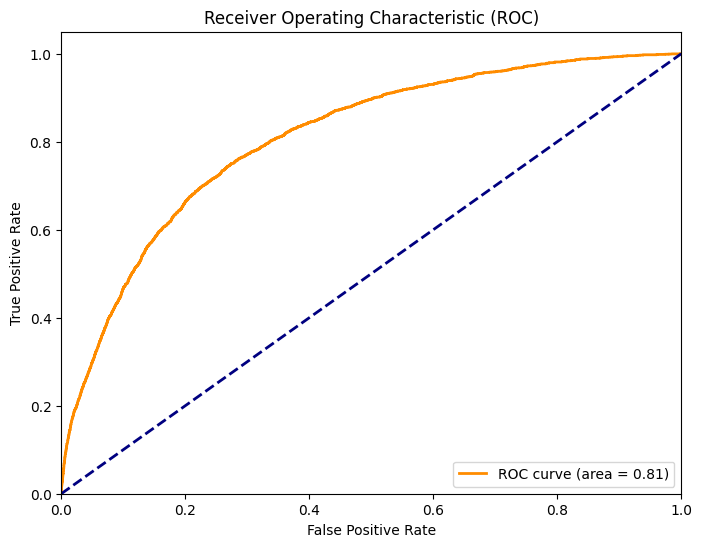

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, test_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

#The dashed line on an ROC curve represents a baseline that indicates 
#the performance of a classifier that makes random predictions.

#### GradientBoosting

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

In [19]:
gbHyperParams = {'loss' : ['deviance', 'exponential'],
                 'n_estimators': randint(10, 500),
                 'max_depth': randint(1,10)}

In [20]:
gridSearchGB = RandomizedSearchCV(estimator=gbMod, param_distributions=gbHyperParams, n_iter=10,
                                   scoring='roc_auc', cv=None, verbose=2)

gridSearchGB.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ....loss=exponential, max_depth=6, n_estimators=259; total time= 7.5min
[CV] END ....loss=exponential, max_depth=6, n_estimators=259; total time=  42.0s
[CV] END ....loss=exponential, max_depth=6, n_estimators=259; total time=  41.6s
[CV] END ....loss=exponential, max_depth=6, n_estimators=259; total time=  41.7s
[CV] END ....loss=exponential, max_depth=6, n_estimators=259; total time=  41.7s
[CV] END .......loss=deviance, max_depth=2, n_estimators=291; total time=   0.0s
[CV] END .......loss=deviance, max_depth=2, n_estimators=291; total time=   0.0s
[CV] END .......loss=deviance, max_depth=2, n_estimators=291; total time=   0.0s
[CV] END .......loss=deviance, max_depth=2, n_estimators=291; total time=   0.0s
[CV] END .......loss=deviance, max_depth=2, n_estimators=291; total time=   0.0s
[CV] END .....loss=exponential, max_depth=1, n_estimators=45; total time=   1.4s
[CV] END .....loss=exponential, max_depth=1, n_e

RandomizedSearchCV(estimator=GradientBoostingClassifier(loss='exponential',
                                                        n_estimators=200),
                   param_distributions={'loss': ['deviance', 'exponential'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x287532010>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x169858ed0>},
                   scoring='roc_auc', verbose=2)

In [21]:
gridSearchGB = RandomizedSearchCV(estimator=gbMod, param_distributions=gbHyperParams, n_iter=10,
                                   scoring='roc_auc', cv=None, verbose=2).fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ....loss=exponential, max_depth=1, n_estimators=124; total time=   3.9s
[CV] END ....loss=exponential, max_depth=1, n_estimators=124; total time=   3.9s
[CV] END ....loss=exponential, max_depth=1, n_estimators=124; total time=   3.9s
[CV] END ....loss=exponential, max_depth=1, n_estimators=124; total time=   3.9s
[CV] END ....loss=exponential, max_depth=1, n_estimators=124; total time=   3.9s
[CV] END .......loss=deviance, max_depth=9, n_estimators=370; total time=   0.0s
[CV] END .......loss=deviance, max_depth=9, n_estimators=370; total time=   0.0s
[CV] END .......loss=deviance, max_depth=9, n_estimators=370; total time=   0.0s
[CV] END .......loss=deviance, max_depth=9, n_estimators=370; total time=   0.0s
[CV] END .......loss=deviance, max_depth=9, n_estimators=370; total time=   0.0s
[CV] END ........loss=deviance, max_depth=8, n_estimators=93; total time=   0.0s
[CV] END ........loss=deviance, max_depth=8, n_e

In [22]:
gridSearchGB.best_params_, gridSearchGB.best_score_

({'loss': 'exponential', 'max_depth': 3, 'n_estimators': 214},
 0.8054002808202618)

### Train models with help of new hyper parameter

In [23]:
bestGbModFitted = gridSearchGB.best_estimator_.fit(X_train, y_train)

In [24]:
test_labels=bestGbModFitted.predict(X_test)

In [25]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.5086284393250603

In [28]:
model_performance(y_test, test_labels)

Accuracy :0.93376
Precision :0.6428571428571429
Recall :0.017971246006389777
F1_score :0.03496503496503497


(0.93376, 0.6428571428571429, 0.017971246006389777, 0.03496503496503497)

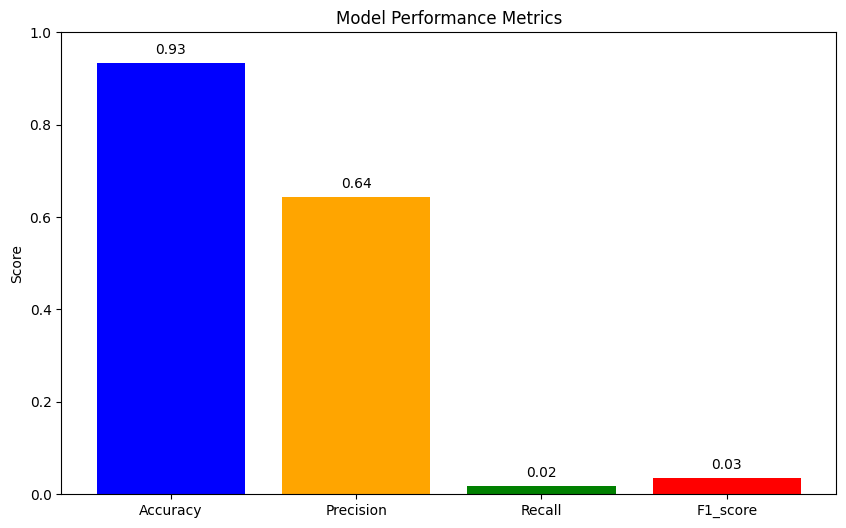

In [29]:
import matplotlib.pyplot as plt

# Performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_score']
values = [0.93376, 0.6428571428571429, 0.017971246006389777, 0.03496503496503497]

# Creating the bar plot
plt.figure(figsize=(10, 6)) # Adjust the figure size as needed
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red']) # You can customize the colors

plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1) # Assuming all values are between 0 and 1

# Display the values on the bars
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center')

plt.show()


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

# Model Evaluation Function
def model_performance(y_test, y_pred) :
    #Show metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    print(f'Accuracy :{Accuracy}')
    print(f'Precision :{Precision}')
    print(f'Recall :{Recall}')
    print(f'F1_score :{F1_score}')

    return Accuracy, Precision, Recall, F1_score

#### Feature importance of final model

In [95]:
X = training_data.drop('seriousdlqin2yrs', axis=1)
y = training_data.seriousdlqin2yrs
features_label = training_data.columns[1:]
forest = RandomForestClassifier (n_estimators = 10000, random_state=0, n_jobs = -1)
forest.fit(X,y)
importances = forest.feature_importances_
indices = np. argsort(importances)[::-1]
for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_label[i],importances[indices[i]]))

 1) revolvingutilizationofunsecuredlines 0.193633
 2) age                            0.180566
 3) numberoftime3059dayspastduenotworse 0.146232
 4) debtratio                      0.127389
 5) monthlyincome                  0.091034
 6) numberofopencreditlinesandloans 0.088507
 7) numberoftimes90dayslate        0.049594
 8) numberrealestateloansorlines   0.047440
 9) numberoftime6089dayspastduenotworse 0.041825
10) numberofdependents             0.033779


In [96]:
test_labels=bestGbModFitted_transformed.predict_proba(np.array(X_test_transform))[:,1]

In [97]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8667103664848695

In [98]:
test_labels=bestAdaModFitted_transformed.predict_proba(np.array(X_test_transform))[:,1]

In [99]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.8625036557274754

#### Feature importance of final model

In [107]:
features_label_1 = training_data.columns[1:]
importances_1 = bestGbModFitted.feature_importances_
indices = np. argsort(importances_1)[::-1]
for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_label_1[i],importances_1[indices[i]]))

 1) revolvingutilizationofunsecuredlines 0.459241
 2) age                            0.190310
 3) numberoftime3059dayspastduenotworse 0.104308
 4) debtratio                      0.098689
 5) monthlyincome                  0.057866
 6) numberofopencreditlinesandloans 0.027856
 7) numberoftimes90dayslate        0.024879
 8) numberrealestateloansorlines   0.018165
 9) numberoftime6089dayspastduenotworse 0.013871
10) numberofdependents             0.004814


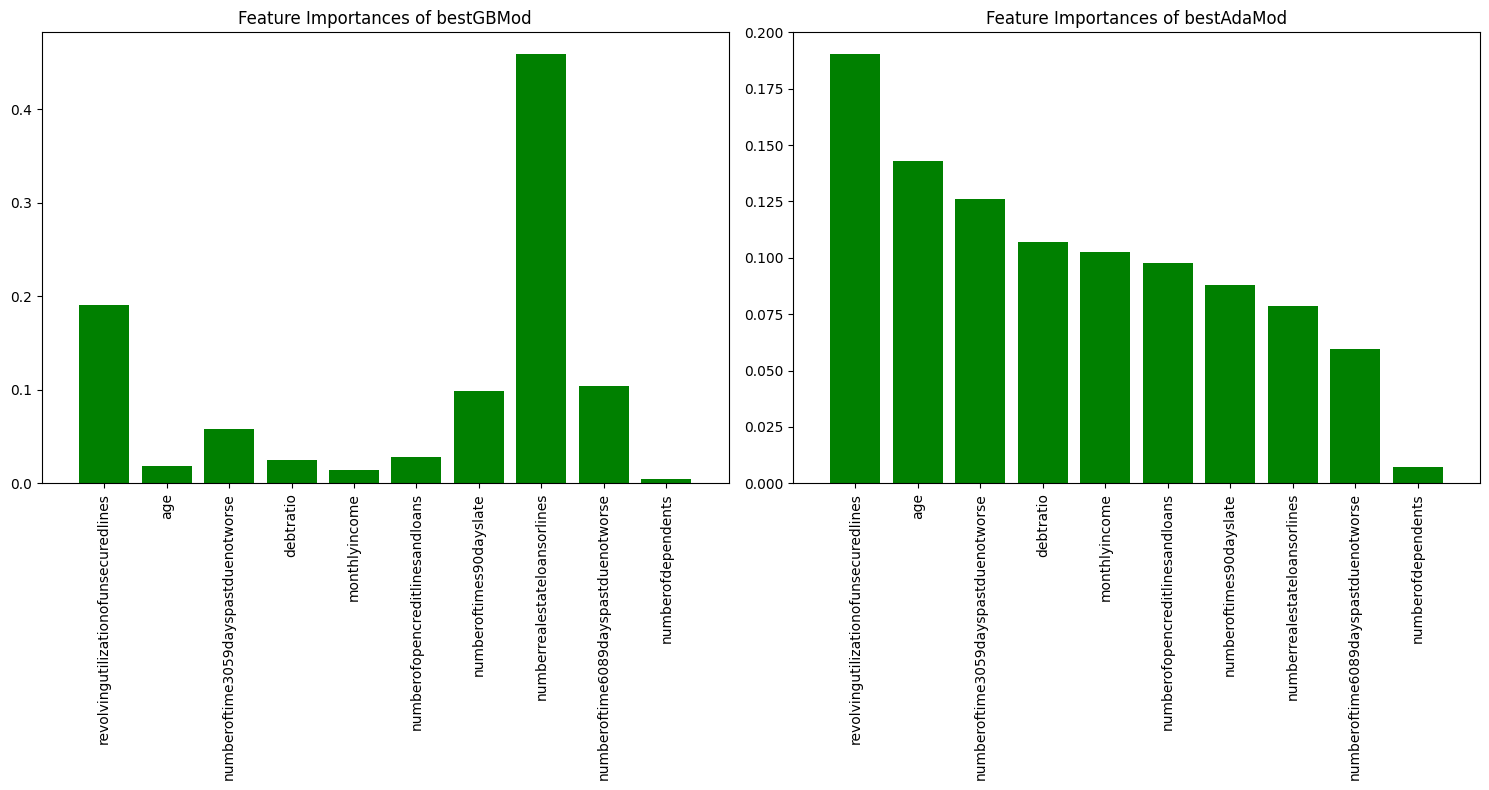

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))  # 1 row, 2 columns, and adjusting the figure size

# Plot for 'Feature Importances of bestGBMod'
ax[0].bar(range(X.shape[1]), importances_1[indices], color="green", align="center")
ax[0].set_xticks(range(X.shape[1]))
ax[0].set_xticklabels(features_label_1, rotation=90)
ax[0].set_xlim([-1, X.shape[1]])
ax[0].set_title('Feature Importances of bestGBMod')


plt.tight_layout()  # Adjust the layout to not overlap
plt.show()

### Testing on Real Test Dataset

In [110]:
# Read Training dataset as well as drop the index column
test_data = pd.read_csv('./cs-test.csv').drop('Unnamed: 0', axis = 1)
# For each column heading we replace "-" and convert the heading in lowercase 
cleancolumn = []
for i in range(len(test_data.columns)):
    cleancolumn.append(test_data.columns[i].replace('-', '').lower())
test_data.columns = cleancolumn

In [111]:
test_data.drop(['seriousdlqin2yrs'], axis=1, inplace=True)
test_data.fillna((training_data.median()), inplace=True)

In [112]:
test_labels_votingMod_old = votingMod_old.predict_proba(np.array(test_data.values))[:,1]
print (len(test_labels_votingMod_old))

101503


In [113]:
output = pd.DataFrame({'ID':test_data.index, 'probability':test_labels_votingMod_old})

In [114]:
output.to_csv("./predictions.csv", index=False)

In [115]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

# need to transfrom the test_data because we use model with transformed model 
transformer = FunctionTransformer(np.log1p)
test_data_temp = np.array(test_data)
test_data_transform = transformer.transform(test_data_temp)

In [116]:
test_labels_votingMod = votingMod.predict_proba(np.array(test_data.values))[:,1]
print (len(test_labels_votingMod_old))

101503


In [117]:
output = pd.DataFrame({'ID':test_data.index, 'probability':test_labels_votingMod})

In [118]:
output.to_csv("./predictions_voting_Feature_transformation.csv", index=False)